# Find centers

Find centers using two different approaches.

In [ ]:
import colorcet  # noqa: F401  # Registers "cet_" prefixed colormaps in plt.colormaps
from geopandas import GeoDataFrame, points_from_xy
from matplotlib import colormaps  # type: ignore  # pyright 1.1.317
from pandas import DataFrame, IndexSlice, NamedAgg
from seaborn import scatterplot
from shapely import LinearRing
from src.boilercv.docs import HIDE

from boilercv.data.sets import get_contours_df, get_dataset
from boilercv.docs import init, nowarn, style_df
from boilercv.images import scale_bool
from boilercv.stages.experiments.e230920_subcool import GBC, bounded_ax

init()

with nowarn(capture=True):
    import trackpy as tp

tp.quiet()

WARM_PALETTE = colormaps["cet_glasbey_warm"]
"""For plotting one approach."""
COOL_PALETTE = colormaps["cet_glasbey_cool"]
"""For plotting the other approach."""
GET_TRACKPY_CENTERS = True
"""Whether to get centers using the Trackpy approach."""
TIME = "2023-09-20T17:14:18"
"""Trial."""
STEP = 10
"""Frame step size."""
STOP = 3
"""Last frame to analyze."""
FRAMES: list[int | None] | None = [None, *[STEP * frame for frame in (STOP, 1)]]
"""Frames.

A list that will become a slice. Not a tuple because `ploomber_engine` can't inject
tuples. Here we automatically scale the frame to stop at by the step size.
"""

HIDE

## Data

Load a video of filled contours and the contour loci and plot a composite of all frames to analyze.

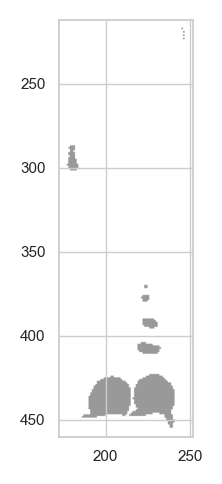

In [ ]:
PATH_TIME = TIME.replace(":", "-")
"""Timestamp suitable for paths.

Also used in notebook parametrization.
"""

frames = slice(*FRAMES) if isinstance(FRAMES, list) else slice(None)  # type: ignore  # pyright: 1.1.336
filled_contours = scale_bool(
    get_dataset(PATH_TIME, frame=frames, stage="filled")["video"]
)
contours_df = get_contours_df(PATH_TIME)
composite_video = filled_contours.max("frame").values
with bounded_ax(composite_video) as ax:
    ax.imshow(~composite_video, alpha=0.4)

HIDE

## Find centers from filled contours using Trackpy

Use Trackpy to find bubble centers given the filled contours.

In [ ]:
GUESS_DIAMETER = 21  # (px) Guess diameter
if GET_TRACKPY_CENTERS:
    trackpy_centers = (
        tp.batch(
            frames=filled_contours.values, diameter=GUESS_DIAMETER, characterize=False
        )
        .drop(columns="mass")
        .assign(
            frame=lambda df: df.frame.replace(
                dict(enumerate(filled_contours.frame.values))
            )
        )
        .sort_values(["frame", "y", "x"], ignore_index=True)
    )
else:
    trackpy_centers = DataFrame()

trackpy_centers

,y,x,frame
0,298.6,180.3,0
1,407.3,224.9,0
2,439.5,197.6,0
3,439.5,233.6,0
4,295.2,179.8,10
5,392.3,225.9,10
6,430.4,227.4,10
7,439.7,197.4,10
8,291.8,179.6,20
9,377.4,223.2,20


## Find centers from contour centroids

The prior approach throws out contour data, instead operating on filled contours. Instead, try using shapely to find centers directly from contour data.

### Prepare to find objects

Prepare a dataframe with columns in a certain order, assign contour data to it, and demote the hiearchical indices to plain columns. Count the number of points in each contour and each frame, keeping only those which have enough points to describe a linear ring. Construct a GeoPandas geometry column and operate on it with Shapely to construct linear rings, returning only their centroids. Also report the number of points in the loci of each contour per frame.

:::{admonition} Note: `groupby` considerations  
:class: dropdown note  
`groupby` operations behave differently depending on the index, so resetting the index befoe grouping, and unpacking `GBC` to set sensible defaults for `groupby`'s keyword arguments, makes it behave less surprisingly. `GBC` enables `observed` and `sort`, and disables `as_index`, `dropna`, and `group_keys`.  
:::

In [ ]:
contours = (
    DataFrame(columns=["xpx", "ypx"])
    .assign(**contours_df.loc[IndexSlice[frames, :], :])
    .rename(axis="columns", mapper=dict(xpx="x", ypx="y"))
    .reset_index()
    .assign(
        count=lambda df: df.groupby(["frame", "contour"], **GBC).x.transform("count")
    )
    .query("count > 3")
    .assign(geometry=lambda df: points_from_xy(df.x, df.y))
    .groupby(["frame", "contour"], **GBC)
    .agg(
        count=NamedAgg(column="count", aggfunc="first"),
        centroid=NamedAgg(
            column="geometry", aggfunc=lambda df: LinearRing(df).centroid
        ),
    )
)
contours

,frame,contour,count,centroid
0,0,0,50,POINT (228.015 439.375)
1,0,1,30,POINT (202.637 437.271)
2,0,2,16,POINT (225.105 407.270)
3,0,3,9,POINT (180.189 298.593)
4,10,1,39,POINT (202.279 437.224)
5,10,2,56,POINT (228.382 438.571)
6,10,3,10,POINT (225.907 392.298)
7,10,4,8,POINT (179.863 295.137)
8,20,0,42,POINT (200.723 438.272)
9,20,1,53,POINT (228.308 438.935)


Split the centroid point objects into separate named columns that conform to the Trackpy convention. Report the centroids in each frame.

In [ ]:
centers = (
    GeoDataFrame(contours)
    .assign(x=lambda df: df.centroid.x, y=lambda df: df.centroid.y)
    .loc[:, ["y", "x", "frame"]]
    .sort_values(["frame", "y", "x"], ignore_index=True)
)
centers

,y,x,frame
0,298.6,180.2,0
1,407.3,225.1,0
2,437.3,202.6,0
3,439.4,228.0,0
4,295.1,179.9,10
5,392.3,225.9,10
6,437.2,202.3,10
7,438.6,228.4,10
8,291.8,179.6,20
9,377.4,223.2,20


## Compare approaches

Compare Trackpy centers with contour centroids. Here the guess radius for Trackpy object finding and contour perimeter filtering are matched to produce the same number of objects from each algorithm. Trackpy features more intelligent filtering, but takes much longer. Trackpy's approach for finding local maxima in grayscale images is applied even to binarized images, exhaustively searching for high points in the binary image, adding to execution time.

The percent difference between the approaches is relatively low for this subset, suggesting the contour centroid approach is reasonable.

In [ ]:
if GET_TRACKPY_CENTERS:
    diffs = (centers - trackpy_centers).abs()

    with style_df(
        DataFrame().assign(dx=diffs.x, dy=diffs.y, frame=trackpy_centers.frame)
    ) as styler:
        styler.background_gradient().hide(axis="index")

dx,dy,frame
0.07367,0.01983,0
0.1967,0.06972,0
5.050,2.183,0
5.604,0.08612,0
0.02017,0.02017,10
0.002872,0.02664,10
25.07,6.801,10
30.98,1.081,10
0.01046,0.05615,20
0.05534,0.0001433,20


A warm color palette is used to plot Trackpy centers, and a cool color palette is used to plot contour centroids.

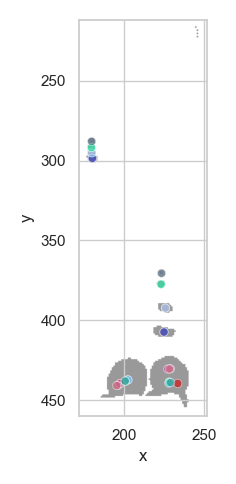

In [ ]:
if GET_TRACKPY_CENTERS:
    scatterplot(
        ax=ax,
        data=trackpy_centers,
        x="x",
        y="y",
        hue="frame",
        alpha=0.6,
        palette=WARM_PALETTE,
        legend=False,
    )
scatterplot(
    ax=ax,
    data=centers,
    x="x",
    y="y",
    hue="frame",
    alpha=0.6,
    palette=COOL_PALETTE,
    legend=False,
)

fig = ax.get_figure()
fig